In [2]:
# Neural Network
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.models import load_model
import statsmodels.api as sm
import tensorflow as tf
import matplotlib.pyplot as plt
#from silence_tensorflow import silence_tensorflow
#silence_tensorflow()

In [3]:
# Check GPU Usage
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.1


In [4]:
# Load the Data
combined_data = pd.read_csv("C:\\Users\\cb7en\\OneDrive\\Documentos\\Stats Master - Wei\\Project\\Monthly\\combined_data.csv", index_col='Date', parse_dates=True)

# check end of the data
combined_data.sort_index(inplace=True)

combined_data.index = pd.to_datetime(combined_data.index)

combined_data.head(5)

,Energy,Temeprature
Date,,
2002-05-31,11874901,11
2002-06-30,12185238,18
2002-07-31,14033343,24
2002-08-31,13748878,23
2002-09-30,12593138,20


In [5]:
# Normalize data
scaler = RobustScaler()
scaled_data = scaler.fit_transform(combined_data)

In [6]:
model_gru = load_model('gru_model_temp.h5')

In [7]:
# Prepare initial input: last 24 months (Dec 2023 - Dec 2024)
lookback = 24
last_sequence = scaled_data[-lookback:]  # Shape: (24, 2)

# Forecast for 60 months (Jan 2025 - Dec 2029)
future_months = 60
predictions = []
current_sequence = last_sequence.copy()

In [8]:
# Approximate future temperature (if no forecast available)
# Use average monthly temperature from historical data
monthly_temp_avg = combined_data['Temeprature'].groupby(combined_data.index.month).mean()

In [9]:
for i in range(future_months):
    # Reshape input for model: (1, lookback, 2)
    X = current_sequence.reshape(1, lookback, 2)
    
    # Predict next energy value (scaled)
    pred_scaled = model_gru.predict(X, verbose=0)[0, 0]
    
    # Get temperature for the next month (cycle through Jan-Dec)
    next_month = (combined_data.index[-1].month + i + 1) % 12 or 12
    temp_scaled = scaler.transform([[0, monthly_temp_avg[next_month]]])[0, 1]
    
    # Combine prediction and temperature
    next_value = np.array([[pred_scaled, temp_scaled]])
    
    # Append to predictions (inverse transform for energy only)
    pred_energy = scaler.inverse_transform(next_value)[:, 0][0]
    predictions.append(pred_energy)
    
    # Update sequence: slide window forward
    current_sequence = np.vstack((current_sequence[1:], next_value))

In [10]:
# Create future dates
future_dates = pd.date_range(start='2025-01-31', periods=future_months, freq='M')

# Combine into DataFrame
forecast_df = pd.DataFrame({'datetime': future_dates, 'predicted_energy': predictions})
pd.options.display.float_format = '{:,.0f}'.format
print(forecast_df)

     datetime  predicted_energy
0  2025-01-31        12,872,515
1  2025-02-28        12,216,125
2  2025-03-31        11,458,048
3  2025-04-30        10,793,147
4  2025-05-31        10,482,586
5  2025-06-30        11,036,163
6  2025-07-31        12,393,981
7  2025-08-31        12,120,260
8  2025-09-30        11,013,643
9  2025-10-31        10,490,797
10 2025-11-30        11,154,626
11 2025-12-31        12,227,333
12 2026-01-31        12,531,532
13 2026-02-28        11,753,052
14 2026-03-31        10,979,628
15 2026-04-30        10,311,488
16 2026-05-31        10,068,717
17 2026-06-30        10,837,666
18 2026-07-31        12,267,611
19 2026-08-31        11,935,586
20 2026-09-30        10,801,482
21 2026-10-31        10,310,741
22 2026-11-30        10,973,077
23 2026-12-31        12,021,527
24 2027-01-31        12,405,271
25 2027-02-28        11,615,128
26 2027-03-31        10,824,588
27 2027-04-30        10,156,960
28 2027-05-31         9,956,707
29 2027-06-30        10,774,563
30 2027-

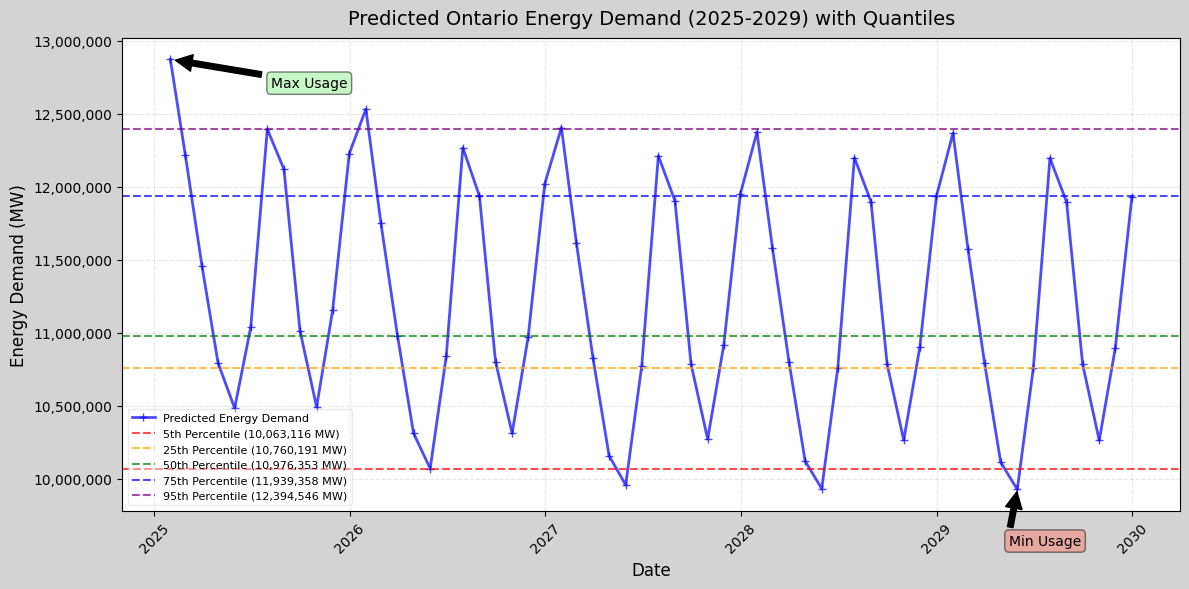

In [11]:
from matplotlib.ticker import ScalarFormatter

# Assuming forecast_df is your 5-year prediction DataFrame
expected = forecast_df.set_index('datetime')['predicted_energy']  # Explicitly select energy column as Series

# Calculate quantiles
quantiles = expected.quantile([0.05, 0.25, 0.50, 0.75, 0.95])

# Define quantile colors
quantile_colors = {0.05: 'red', 0.25: 'orange', 0.50: 'green', 0.75: 'blue', 0.95: 'purple'}

# Create plot
plt.figure(figsize=(12, 6), facecolor='lightgray')
ax = plt.gca()
ax.set_facecolor('white')  # Cleaner background for contrast

# Plot energy demand time series
plt.plot(expected.index, expected, label='Predicted Energy Demand',  marker="+",color='blue', alpha=0.7, linewidth=2)

# Add quantile lines
for q, value in quantiles.items():
    plt.axhline(y=value, color=quantile_colors[q], linestyle='--', alpha=0.7, 
                label=f'{int(q*100)}th Percentile ({value:,.0f} MW)')

# Annotations for max and min
max_idx, max_val = expected.idxmax(), expected.max()
min_idx, min_val = expected.idxmin(), expected.min()

plt.annotate('Max Usage', xy=(max_idx, max_val), xytext=(100, -20), textcoords='offset points',
             ha='center', arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", alpha=0.5))
plt.annotate('Min Usage', xy=(min_idx, min_val), xytext=(20, -40), textcoords='offset points',
             ha='center', arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.3", fc="salmon", alpha=0.5))

# Customize plot
plt.title('Predicted Ontario Energy Demand (2025-2029) with Quantiles', fontsize=14, pad=10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Demand (MW)', fontsize=12)
plt.legend(loc='best', fontsize=8, framealpha=0.4)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Disable scientific notation on y-axis and add thousand separators
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='plain', axis='y')  # Alternative method
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.tight_layout()

# Show plot
plt.show()

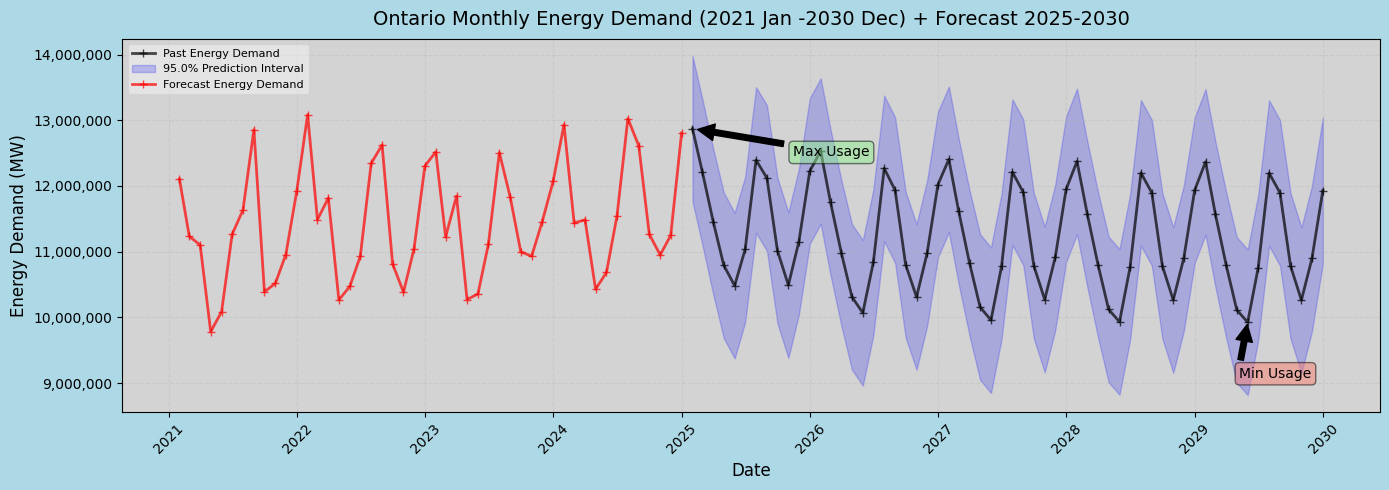

In [29]:
plt.figure(figsize=(14, 5), facecolor='lightblue')
ax = plt.gca()
ax.set_facecolor('lightgray')  # Cleaner background for contrast

# Plot energy demand time series
plt.plot(expected.index, expected, label='Past Energy Demand',  marker="+",color='black', alpha=0.7, linewidth=2)
plt.fill_between(forecast_df.index, forecast_df['lower_bound'], forecast_df['upper_bound'], 
                 color='blue', alpha=0.2, label=f'{confidence_level*100}% Prediction Interval')
plt.plot(combined_data['Energy'].iloc[-48:].index, combined_data['Energy'].iloc[-48:], label='Forecast Energy Demand',  marker="+",color='red', alpha=0.7, linewidth=2)


# Annotations for max and min
max_idx, max_val = expected.idxmax(), expected.max()
min_idx, min_val = expected.idxmin(), expected.min()

plt.annotate('Max Usage', xy=(max_idx, max_val), xytext=(100, -20), textcoords='offset points',
             ha='center', arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", alpha=0.5))
plt.annotate('Min Usage', xy=(min_idx, min_val), xytext=(20, -40), textcoords='offset points',
             ha='center', arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.3", fc="salmon", alpha=0.5))

# Customize plot
plt.title('Ontario Monthly Energy Demand (2021 Jan -2030 Dec) + Forecast 2025-2030', fontsize=14, pad=10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Demand (MW)', fontsize=12)
plt.legend(loc='best', fontsize=8, framealpha=0.4)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Disable scientific notation on y-axis and add thousand separators
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='plain', axis='y')  # Alternative method
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.tight_layout()
fig=plt.gcf()
fig.savefig("pics\\energy_11.png", dpi=300)
# Show plot
plt.show()

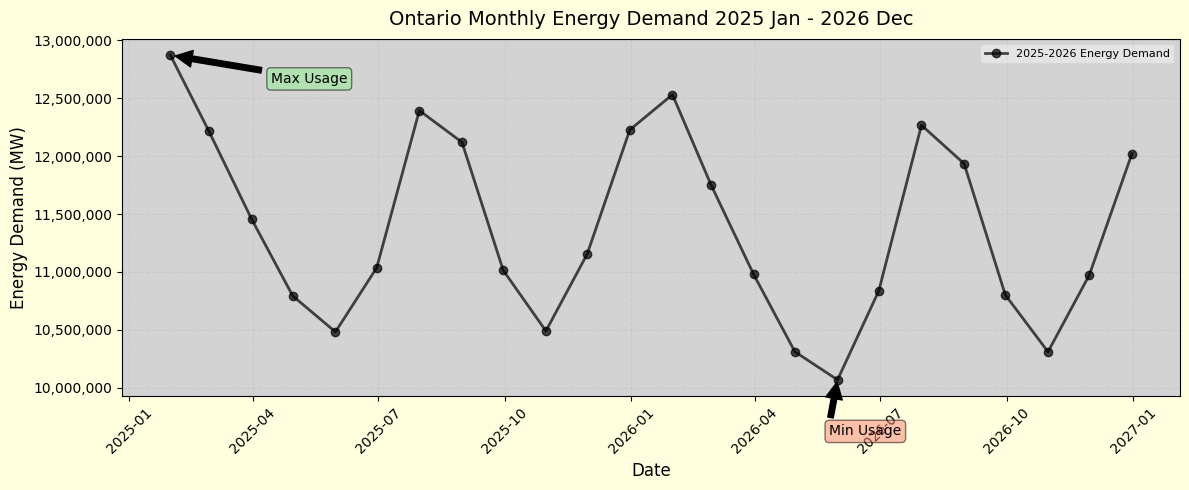

In [13]:
plt.figure(figsize=(12, 5), facecolor='lightyellow')
ax = plt.gca()
ax.set_facecolor('lightgray')  # Cleaner background for contrast

# Plot energy demand time series
plt.plot(expected.iloc[:24].index, expected.iloc[:24], label='2025-2026 Energy Demand',  marker="o",color='black', alpha=0.7, linewidth=2)

# Annotations for max and min
max_idx, max_val = expected.iloc[:24].idxmax(), expected.iloc[:24].max()
min_idx, min_val = expected.iloc[:24].idxmin(), expected.iloc[:24].min()

plt.annotate('Max Usage', xy=(max_idx, max_val), xytext=(100, -20), textcoords='offset points',
             ha='center', arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", alpha=0.5))
plt.annotate('Min Usage', xy=(min_idx, min_val), xytext=(20, -40), textcoords='offset points',
             ha='center', arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.3", fc="salmon", alpha=0.5))

# Customize plot
plt.title('Ontario Monthly Energy Demand 2025 Jan - 2026 Dec', fontsize=14, pad=10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Demand (MW)', fontsize=12)
plt.legend(loc='best', fontsize=8, framealpha=0.4)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Disable scientific notation on y-axis and add thousand separators
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='plain', axis='y')  # Alternative method
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.tight_layout()

# Show plot
plt.show()

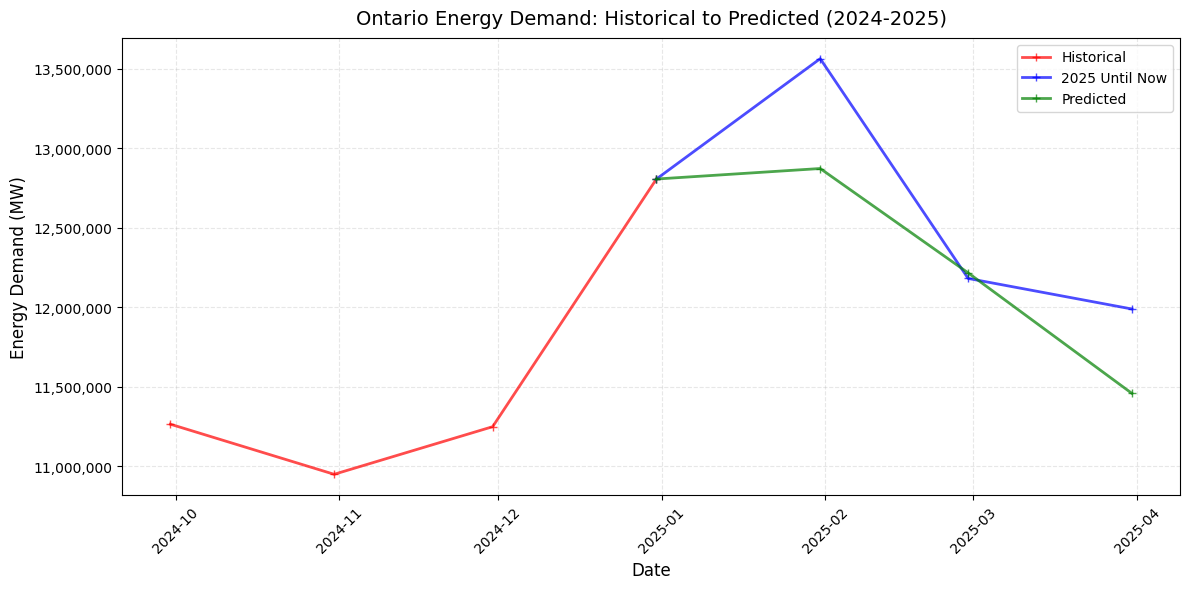

In [14]:
# Comparing predicted with Real Demand from Jan to March (now March 22) 2025
# Import Real data  - Demand
real_data = pd.read_csv("C:\\Users\\cb7en\\OneDrive\\Documentos\\Stats Master - Wei\\Energy Data\\2025 Data\\PUB_Demand_2025.csv", index_col='Date', parse_dates=True)

real_data.index = pd.to_datetime(real_data.index)

y25_tot = real_data['Ontario Demand'].resample('ME').sum()
y25_tot = y25_tot.iloc[:-1]

# Vizualize Historical + Now + Predicted (all together)

# convert indexes/indices are datetime
combined_data.index = pd.to_datetime(combined_data.index)
y25_tot.index = pd.to_datetime(y25_tot.index)
expected.index = pd.to_datetime(expected.index)

# Extract the segments
historical = combined_data['Energy'].iloc[-4:]
until_now = y25_tot
predicted = expected.iloc[:3]

# Create overlapping points to connect the lines
# Last point of historical becomes first point of until_now
historical_to_until_now = pd.concat([
    pd.Series(historical.iloc[-1], index=[historical.index[-1]]),  # Last historical point
    until_now  # All of until_now
])

# Last point of until_now becomes first point of predicted
until_now_to_predicted = pd.concat([
    pd.Series(historical.iloc[-1], index=[historical.index[-1]]),  # Last until_now point
    predicted  # All of predicted
])

# Plot each segment with overlap to ensure connection
plt.figure(figsize=(12, 6))
plt.plot(historical.index, historical, label='Historical', marker="+", color='red', alpha=0.7, linewidth=2)
plt.plot(historical_to_until_now.index, historical_to_until_now, label='2025 Until Now', marker="+", color='blue', alpha=0.7, linewidth=2)
plt.plot(until_now_to_predicted.index, until_now_to_predicted, label='Predicted', marker="+", color='green', alpha=0.7, linewidth=2)

# Customize plot
plt.title('Ontario Energy Demand: Historical to Predicted (2024-2025)', fontsize=14, pad=10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Demand (MW)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Disable scientific notation on y-axis and add thousand separators
ax = plt.gca()
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='plain', axis='y')
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.tight_layout()
plt.show()

In [15]:
model_gru = load_model('gru_model_temp.h5')

In [16]:
# Normalize data
scaler = RobustScaler()
scaled_data = scaler.fit_transform(combined_data)

# Define lookback
lookback = 24

# Create sequences
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])  # Shape: (lookback, 2)
    y.append(scaled_data[i, 0])          # Energy only
X, y = np.array(X), np.array(y)

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Get point predictions on calibration set (validation)
y_val_pred_scaled = model_gru.predict(X_val)
y_val_pred_scaled_full = np.zeros((len(y_val_pred_scaled), 2))
y_val_pred_scaled_full[:, 0] = y_val_pred_scaled[:, 0]
y_val_pred = scaler.inverse_transform(y_val_pred_scaled_full)[:, 0]
y_val_orig = scaler.inverse_transform(np.column_stack((y_val, X_val[:, -1, 1])))[:, 0]

2/2 [==============================] - 1s 20ms/step


In [17]:
# Compute nonconformity scores (absolute errors) on calibration set
nonconformity_scores = np.abs(y_val_orig - y_val_pred)

# Sort scores to find the threshold for a given confidence level
confidence_level = 0.95  # 95% confidence
alpha = 1 - confidence_level  # Significance level
quantile_index = int((1 - alpha) * (len(nonconformity_scores) + 1))
score_threshold = np.sort(nonconformity_scores)[quantile_index - 1]
print(f"Score threshold for {confidence_level*100}% confidence: {score_threshold:,.0f} MW")

Score threshold for 95.0% confidence: 1,108,401 MW


In [18]:
# Load forecast data
# forecast_df = pd.read_csv('energy_forecast_2025_2029.csv', parse_dates=['datetime'])
forecast_df.set_index('datetime', inplace=True)

# Apply CP to get prediction intervals
lower_bounds = forecast_df['predicted_energy'] - score_threshold
upper_bounds = forecast_df['predicted_energy'] + score_threshold

# Add intervals to forecast_df
forecast_df['lower_bound'] = lower_bounds
forecast_df['upper_bound'] = upper_bounds

# Print sample of forecast with intervals
print(forecast_df.head())
forecast_df.to_csv('energy_forecast_with_intervals_2025_2029.csv')

            predicted_energy  lower_bound  upper_bound
datetime                                              
2025-01-31        12,872,515   11,764,114   13,980,917
2025-02-28        12,216,125   11,107,724   13,324,526
2025-03-31        11,458,048   10,349,647   12,566,449
2025-04-30        10,793,147    9,684,746   11,901,548
2025-05-31        10,482,586    9,374,185   11,590,987


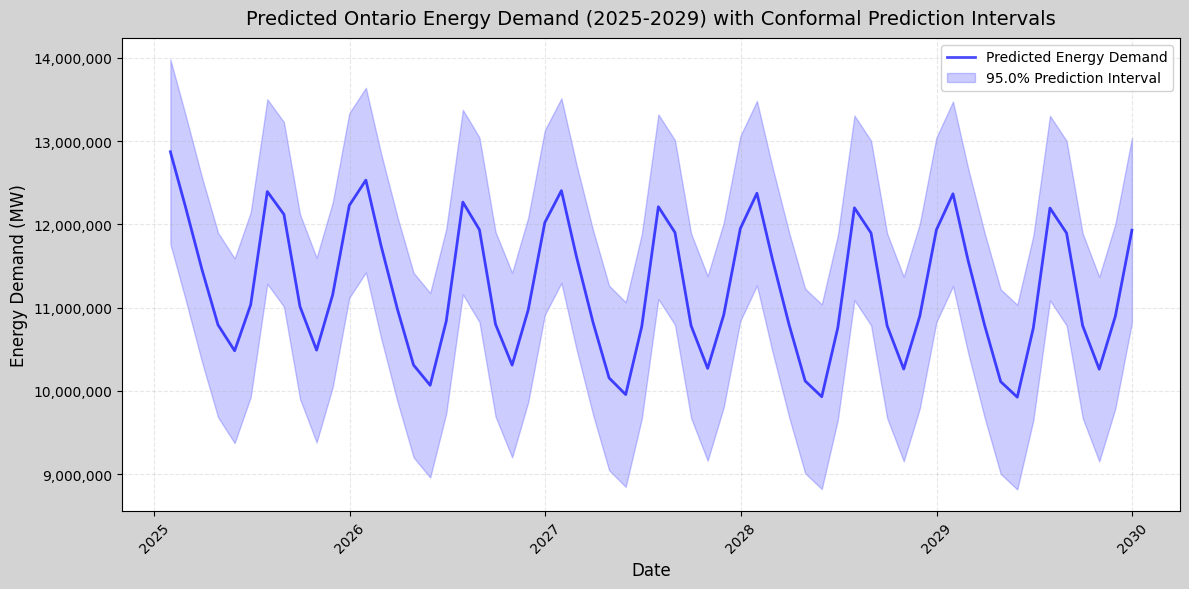

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Plot forecast with prediction intervals
plt.figure(figsize=(12, 6), facecolor='lightgray')
ax = plt.gca()
ax.set_facecolor('white')

# Plot predicted energy demand
plt.plot(forecast_df.index, forecast_df['predicted_energy'], label='Predicted Energy Demand', color='blue', alpha=0.7, linewidth=2)

# Plot prediction intervals
plt.fill_between(forecast_df.index, forecast_df['lower_bound'], forecast_df['upper_bound'], 
                 color='blue', alpha=0.2, label=f'{confidence_level*100}% Prediction Interval')

# Customize plot
plt.title('Predicted Ontario Energy Demand (2025-2029) with Conformal Prediction Intervals', fontsize=14, pad=10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Demand (MW)', fontsize=12)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Disable scientific notation on y-axis and add thousand separators
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='plain', axis='y')
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.tight_layout()

fig=plt.gcf()
fig.savefig("pics\\energy_12.png", dpi=300)
plt.show()

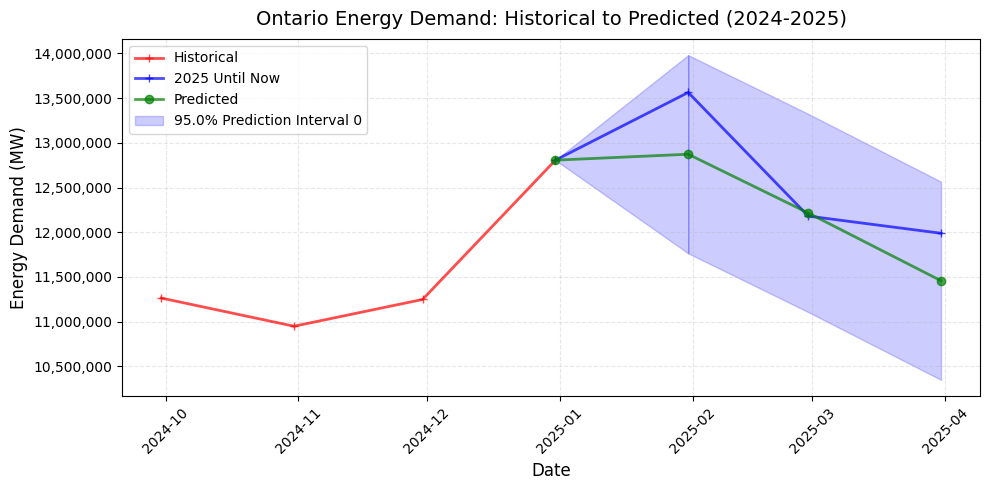

In [20]:
# convert indexes/indices are datetime
combined_data.index = pd.to_datetime(combined_data.index)
y25_tot.index = pd.to_datetime(y25_tot.index)
expected.index = pd.to_datetime(expected.index)

# Extract the segments
historical = combined_data['Energy'].iloc[-4:]
until_now = y25_tot
predicted = expected.iloc[:3]

# Create overlapping points to connect the lines
# Last point of historical becomes first point of until_now
historical_to_until_now = pd.concat([
    pd.Series(historical.iloc[-1], index=[historical.index[-1]]),  # Last historical point
    until_now  # All of until_now
])

# Last point of until_now becomes first point of predicted
until_now_to_predicted = pd.concat([
    pd.Series(historical.iloc[-1], index=[historical.index[-1]]),  # Last until_now point
    predicted  # All of predicted
])

# Get the last historical point's value to start the bounds
last_historical_value = historical.iloc[-1]
last_historical_date = historical.index[-1]

# Extract the upper and lower bounds from forecast_df
lower_bound = forecast_df['lower_bound'].iloc[:1]
upper_bound = forecast_df['upper_bound'].iloc[:1]

# Prepend the last historical value to the bounds to ensure connection
# We use the last historical date as the starting point for the bounds
extended_lower_bound = pd.concat([
    pd.Series(last_historical_value, index=[last_historical_date]),  # Start at last historical point
    lower_bound
])
extended_upper_bound = pd.concat([
    pd.Series(last_historical_value, index=[last_historical_date]),  # Start at last historical point
    upper_bound
])

# Plot each segment with overlap to ensure connection
plt.figure(figsize=(10, 5))
plt.plot(historical.index, historical, label='Historical', marker="+", color='red', alpha=0.7, linewidth=2)
plt.plot(historical_to_until_now.index, historical_to_until_now, label='2025 Until Now', marker="+", color='blue', alpha=0.7, linewidth=2)
plt.plot(until_now_to_predicted.index, until_now_to_predicted, label='Predicted', marker="o", color='green', alpha=0.7, linewidth=2)

plt.fill_between(forecast_df.iloc[:3].index, forecast_df['lower_bound'].iloc[:3], forecast_df['upper_bound'].iloc[:3], 
                 color='blue', alpha=0.2)

# Plot the prediction interval, now starting from the last historical point
plt.fill_between(
    extended_lower_bound.index, 
    extended_lower_bound, 
    extended_upper_bound, 
    color='blue', 
    alpha=0.2, 
    label=f'{confidence_level*100}% Prediction Interval 0'
)
# Customize plot
plt.title('Ontario Energy Demand: Historical to Predicted (2024-2025)', fontsize=14, pad=10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Demand (MW)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Disable scientific notation on y-axis and add thousand separators
ax = plt.gca()
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='plain', axis='y')
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.tight_layout()

fig=plt.gcf()
fig.savefig("pics\\energy_13.png", dpi=300)
plt.show()

In [21]:
forecast_df.resample('YE').sum()

,predicted_energy,lower_bound,upper_bound
datetime,,,
2025-12-31,"138,259,224","124,958,410","151,560,039"
2026-12-31,"134,792,109","121,491,294","148,092,923"
2027-12-31,"133,767,515","120,466,701","147,068,329"
2028-12-31,"133,538,831","120,238,017","146,839,645"
2029-12-31,"133,490,016","120,189,202","146,790,830"


Increase Energy Demand - Monthly increase (2029 vs. 2024)

- Data Centers (AI-Driven): 3.82 TWh ÷ (5 × 12) = 63,667 MWh/month.
- Electric Vehicles (EVs):  2.693 TWh ÷ (5 x 12) = 44,883 MWh/month.
- Other Electronic Devices: 2.725 TWh ÷ (5 × 12) = 45,417 MWh/month.
-  153,967 MWh/month

According to IESO Expects:

- Tot demand grow 75% by 2050
- Tot demand 2025 to be 151 TWh
- yearly increase of 1.7% ~ 214,000 MW/month
- Adjustment

214,000 MW/month ~ 64% of 333,501 MWh/month
Final monthly increase adopted = 70% of 333,501 MWh/month
~ 70% 0f 333,501 MWh/month = 234,000 MWh/month

In [22]:
# forecast_df.set_index('datetime', inplace=True)

# Calculate monthly increase ramp-up
total_months = 60  # Jan 2025 to Dec 2029

# Generate cumulative increases for each month
cumulative_increases = np.linspace(153967*0.6, 153967*0.6*12*5, total_months)

# Function to convert linear to stochastic data
def linear_to_stochastic(linear_data, noise_std, seed=42):
    np.random.seed(seed)
    noise = np.random.normal(0, noise_std, len(linear_data))
    stochastic_data = linear_data + noise
    return stochastic_data

noise_std = 1000000 # it comes from Time-Series Residual (Unsmoothed) -1/+1 million MW

cumulative_increases_adj = linear_to_stochastic(cumulative_increases, noise_std)
# Add increases to predicted energy demand
forecast_df['adjusted_predicted_energy'] = forecast_df['predicted_energy'] + cumulative_increases_adj

In [23]:
# Adjust prediction intervals (if using conformal prediction from earlier)
# Assuming intervals are symmetric around the point prediction
forecast_df['adjusted_lower_bound'] = forecast_df['adjusted_predicted_energy'] - score_threshold
forecast_df['adjusted_upper_bound'] = forecast_df['adjusted_predicted_energy'] + score_threshold

# Print updated forecast
#forecast_df[['predicted_energy', 'adjusted_predicted_energy', 'adjusted_lower_bound', 'adjusted_upper_bound']]
forecast_df

,predicted_energy,lower_bound,upper_bound,adjusted_predicted_energy,adjusted_lower_bound,adjusted_upper_bound
datetime,,,,,,
2025-01-31,"12,872,515","11,764,114","13,980,917","13,461,610","12,353,209","14,570,011"
2025-02-28,"12,216,125","11,107,724","13,324,526","12,262,621","11,154,220","13,371,022"
2025-03-31,"11,458,048","10,349,647","12,566,449","12,382,877","11,274,476","13,491,279"
2025-04-30,"10,793,147","9,684,746","11,901,548","12,685,697","11,577,296","13,794,099"
2025-05-31,"10,482,586","9,374,185","11,590,987","10,710,334","9,601,932","11,818,735"
2025-06-30,"11,036,163","9,927,762","12,144,564","11,356,307","10,247,906","12,464,708"
2025-07-31,"12,393,981","11,285,580","13,502,382","14,619,855","13,511,454","15,728,257"
2025-08-31,"12,120,260","11,011,859","13,228,661","13,626,736","12,518,335","14,735,137"
2025-09-30,"11,013,643","9,905,241","12,122,044","11,375,590","10,267,189","12,483,991"


In [24]:
forecast_df.resample('YE').sum()

,predicted_energy,lower_bound,upper_bound,adjusted_predicted_energy,adjusted_lower_bound,adjusted_upper_bound
datetime,,,,,,
2025-12-31,"138,259,224","124,958,410","151,560,039","149,016,344","135,715,530","162,317,158"
2026-12-31,"134,792,109","121,491,294","148,092,923","148,205,731","134,904,916","161,506,545"
2027-12-31,"133,767,515","120,466,701","147,068,329","165,258,645","151,957,831","178,559,459"
2028-12-31,"133,538,831","120,238,017","146,839,645","176,661,802","163,360,988","189,962,616"
2029-12-31,"133,490,016","120,189,202","146,790,830","194,481,659","181,180,845","207,782,473"


In [25]:
forecast_df.to_csv('energy_Forecast.csv', index=False)

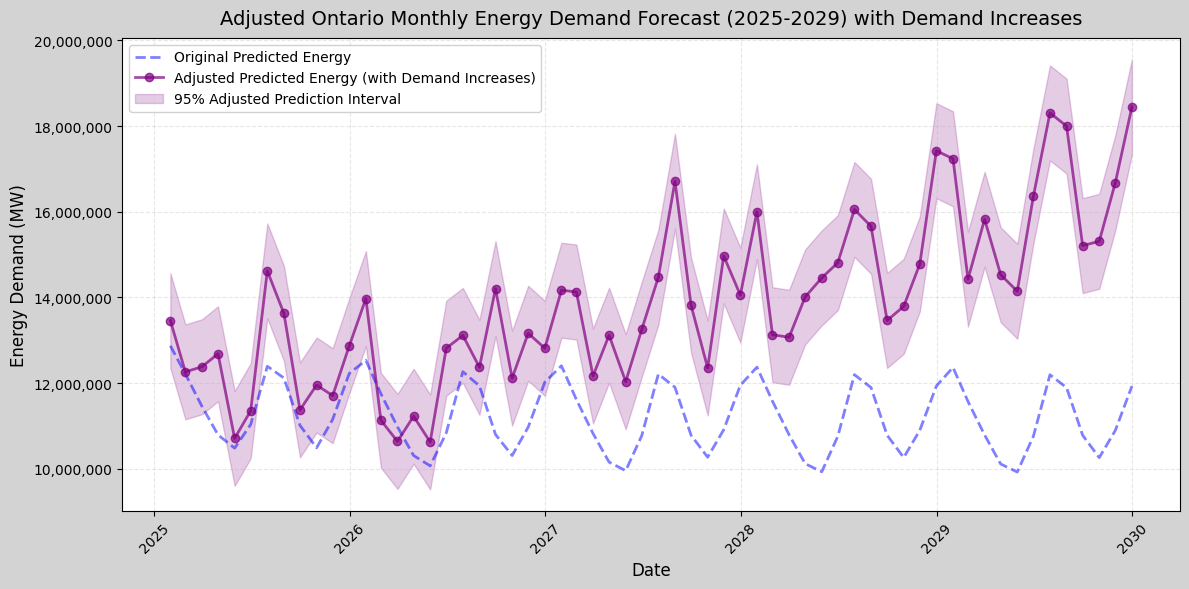

In [26]:
# Plot original and adjusted forecasts
plt.figure(figsize=(12, 6), facecolor='lightgray')
ax = plt.gca()
ax.set_facecolor('white')

# Original prediction
plt.plot(forecast_df.index, forecast_df['predicted_energy'], label='Original Predicted Energy', color='blue', alpha=0.5, linestyle='--',linewidth=2)

# Adjusted prediction
plt.plot(forecast_df.index, forecast_df['adjusted_predicted_energy'], label='Adjusted Predicted Energy (with Demand Increases)', 
         marker="o", color='purple', alpha=0.7, linewidth=2)

# Adjusted prediction intervals
plt.fill_between(forecast_df.index, forecast_df['adjusted_lower_bound'], forecast_df['adjusted_upper_bound'], 
                 color='purple', alpha=0.2, label='95% Adjusted Prediction Interval')

# Customize plot
plt.title('Adjusted Ontario Monthly Energy Demand Forecast (2025-2029) with Demand Increases', fontsize=14, pad=10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Demand (MW)', fontsize=12)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Disable scientific notation on y-axis and add thousand separators
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='plain', axis='y')
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.tight_layout()
fig=plt.gcf()
fig.savefig("pics\\energy_14.png", dpi=300)
plt.show()

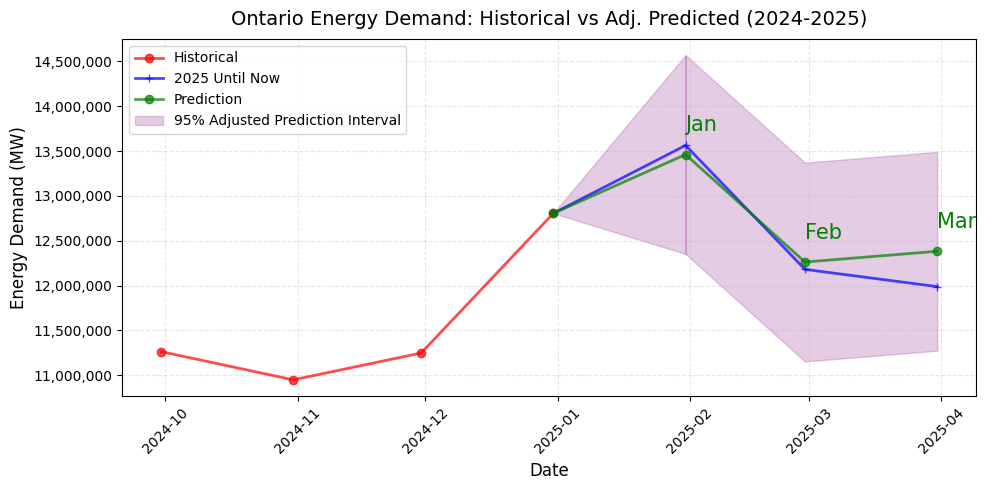

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# [Your existing data preparation code remains unchanged]
# convert indexes/indices are datetime
combined_data.index = pd.to_datetime(combined_data.index)
y25_tot.index = pd.to_datetime(y25_tot.index)
expected.index = pd.to_datetime(forecast_df['adjusted_upper_bound'].index)

# Extract the segments
historical = combined_data['Energy'].iloc[-4:]
until_now = y25_tot
predicted = forecast_df['adjusted_predicted_energy'].iloc[:3]

# Create overlapping points to connect the lines
historical_to_until_now = pd.concat([
    pd.Series(historical.iloc[-1], index=[historical.index[-1]]),
    until_now
])

until_now_to_predicted = pd.concat([
    pd.Series(historical.iloc[-1], index=[historical.index[-1]]),
    predicted
])

# Get the last historical point's value to start the bounds
last_historical_value = historical.iloc[-1]
last_historical_date = historical.index[-1]

# Extract the upper and lower bounds from forecast_df
lower_bound = forecast_df['adjusted_lower_bound'].iloc[:1]
upper_bound = forecast_df['adjusted_upper_bound'].iloc[:1]

# Prepend the last historical value to the bounds to ensure connection
extended_lower_bound = pd.concat([
    pd.Series(last_historical_value, index=[last_historical_date]),
    lower_bound
])
extended_upper_bound = pd.concat([
    pd.Series(last_historical_value, index=[last_historical_date]),
    upper_bound
])

# Plot each segment with overlap to ensure connection
plt.figure(figsize=(10, 5))
plt.plot(historical.index, historical, label='Historical', marker="o", color='red', alpha=0.7, linewidth=2)
plt.plot(historical_to_until_now.index, historical_to_until_now, label='2025 Until Now', marker="+", color='blue', alpha=0.7, linewidth=2)
plt.plot(until_now_to_predicted.index, until_now_to_predicted, label='Prediction', marker="o", color='green', alpha=0.7, linewidth=2)
plt.fill_between(forecast_df.iloc[:3].index, forecast_df['adjusted_lower_bound'].iloc[:3], forecast_df['adjusted_upper_bound'].iloc[:3], 
                 color='purple', alpha=0.2, label='95% Adjusted Prediction Interval')

plt.fill_between(
    extended_lower_bound.index, 
    extended_lower_bound, 
    extended_upper_bound, 
    color='purple', 
    alpha=0.2)

# Add month names at the predicted points
month_names = ['Jan', 'Feb', 'Mar']
for i, (date, value) in enumerate(zip(until_now_to_predicted.index, until_now_to_predicted)):
    # Skip the first point if it's the overlap with historical data
    if i == 0 and date == historical.index[-1]:
        continue
    # Place the text slightly above the marker
    plt.text(date, value+(60**3), month_names[i-1], 
             ha='left', va='bottom', fontsize=15, color='green')

# Customize plot
plt.title('Ontario Energy Demand: Historical vs Adj. Predicted (2024-2025)', fontsize=14, pad=10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Demand (MW)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Disable scientific notation on y-axis and add thousand separators
ax = plt.gca()
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='plain', axis='y')
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.tight_layout()

fig=plt.gcf()
fig.savefig("pics\\energy_15.png", dpi=300)
plt.show()